In [1]:
# this attempts to do the same thing as the otoro blog, but with a delta distribution instead
# http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tqdm import tnrange, tqdm_notebook

/home/gram/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures
NOUT = KMIX * 1 # delta center

NSAMPLE = 2400

In [4]:
y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

In [5]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

In [6]:
hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

In [7]:
def get_mixture_coef(output):
    out_d = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    
    out_d = tf.scalar_mul(1, output)
    
    return out_d

In [8]:
out_d = get_mixture_coef(output)

In [9]:
def tf_normal(y, d):
    result = tf.subtract(y, d)
    
    return result

def get_lossfunc(out_d, y):
    result = tf_normal(y, out_d)
    
    return tf.reduce_mean(result)

In [10]:
lossfunc = get_lossfunc(out_d, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NEPOCH = 10000
loss = np.zeros(NEPOCH)

for i in tnrange(NEPOCH, desc='epoch #'):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})
    loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})
    
    if i == NEPOCH - 1:
        net_out = tf.Tensor.eval(out_d,feed_dict={x: x_data, y: y_data})

HBox(children=(IntProgress(value=0, description='epoch #', max=10000), HTML(value='')))

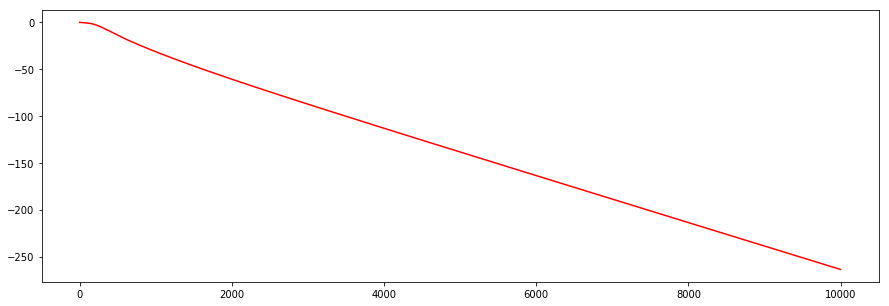

In [12]:
plt.figure(figsize=(15, 5))
#plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.plot(range(NEPOCH), loss, 'r-')
plt.show()

In [13]:
net_out

array([[262.08926, 262.96527, 261.30908, ..., 262.7265 , 265.01538,
        258.7944 ],
       [262.0904 , 262.9664 , 261.31018, ..., 262.7276 , 265.0165 ,
        258.7955 ],
       [262.09006, 262.96606, 261.3098 , ..., 262.72726, 265.01617,
        258.79517],
       ...,
       [262.08997, 262.96597, 261.30975, ..., 262.7272 , 265.01608,
        258.79507],
       [262.08942, 262.9654 , 261.30923, ..., 262.72665, 265.01553,
        258.79456],
       [262.09003, 262.96603, 261.3098 , ..., 262.72723, 265.01614,
        258.79514]], dtype=float32)

In [14]:
num = 2000

print(x_data[num])
print(y_data[num])
print(net_out[num])

[-3.5634005]
[6.643921]
[262.08987 262.96585 261.3097  266.35516 263.643   263.9947  260.52423
 264.2165  266.5725  265.1368  264.64145 264.3848  266.30936 261.18484
 268.02243 269.2764  260.01086 265.58234 260.25528 263.11    262.49484
 262.72705 265.016   258.79498]


In [15]:
print('x:', np.transpose(x_data[np.where((x_data > -0.1) & (x_data < 0.1))[0]]))
print('y:', np.transpose(y_data[np.where((x_data > -0.1) & (x_data < 0.1))[0]]))

x: [[ 0.01729184  0.08954585  0.08608693 -0.0285517   0.08701086 -0.03470977
   0.02799356 -0.01629966  0.02618909 -0.07065552  0.08336842 -0.02339363
   0.04778481  0.09475839  0.00753129  0.02124003 -0.03490294  0.0526185
  -0.01146233 -0.09941839  0.05058432  0.0167824  -0.00263691  0.09724759
  -0.07659686]]
y: [[ 4.438094   -7.289033    4.505736   -4.7413416   5.210158   -7.663549
   7.3140054   7.4404087  -7.4447465  -4.5190954   4.933526    0.19336691
  -0.3294025  -4.250424   -7.7458086   7.592248    0.01079827 -4.9933896
  -4.6419635  -7.637729    5.095172    7.385986    0.17640544 -7.605662
   4.9338326 ]]


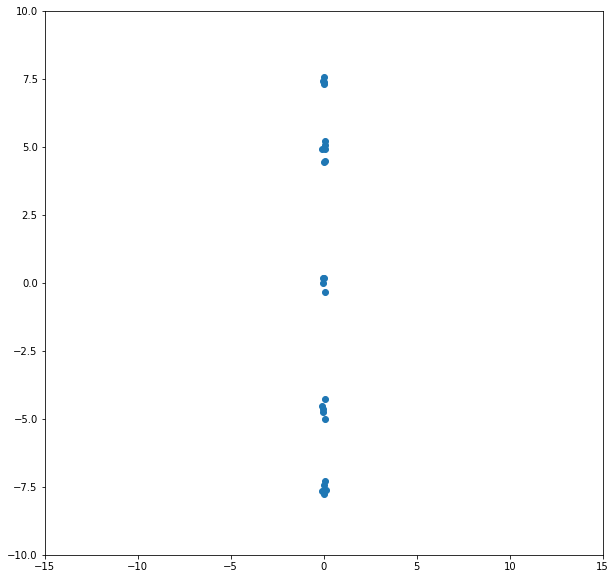

In [16]:
plt.figure(figsize=(10,10))

plt.scatter(x_data[np.where((x_data > -0.1) & (x_data < 0.1))[0]], y_data[np.where((x_data > -0.1) & (x_data < 0.1))[0]])

plt.xlim(-15,15)
plt.ylim(-10,10)
plt.show()

In [17]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

In [21]:
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_d, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    idx = 0

    # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_d[i])
            result[i, j] = rn[i, j]
    return result

In [37]:
for j in range(0,10):
    for i in range(0,NTEST):
        print(get_pi_idx(np.random.rand(NTEST, 10)[i, j], net_out[i]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [29]:
net_out[1]

array([262.0904 , 262.9664 , 261.31018, 266.35568, 263.64355, 263.99524,
       260.52475, 264.217  , 266.5731 , 265.13733, 264.642  , 264.38535,
       266.3099 , 261.18536, 268.023  , 269.27692, 260.01138, 265.5829 ,
       260.25577, 263.11047, 262.49533, 262.7276 , 265.0165 , 258.7955 ],
      dtype=float32)

In [27]:
out_pi_test

array([[262.0906 , 262.96658, 261.3104 , ..., 262.7278 , 265.01672,
        258.7957 ],
       [262.0906 , 262.96658, 261.31036, ..., 262.7278 , 265.01672,
        258.7957 ],
       [262.0906 , 262.96658, 261.31033, ..., 262.72778, 265.0167 ,
        258.7957 ],
       ...,
       [262.08862, 262.96463, 261.30847, ..., 262.72583, 265.01474,
        258.79373],
       [262.08862, 262.96463, 261.30844, ..., 262.72586, 265.01474,
        258.79376],
       [262.08862, 262.96463, 261.30847, ..., 262.72583, 265.0147 ,
        258.79373]], dtype=float32)

In [22]:
out_pi_test = sess.run(get_mixture_coef(output), feed_dict={x: x_test})

y_test = generate_ensemble(out_pi_test)

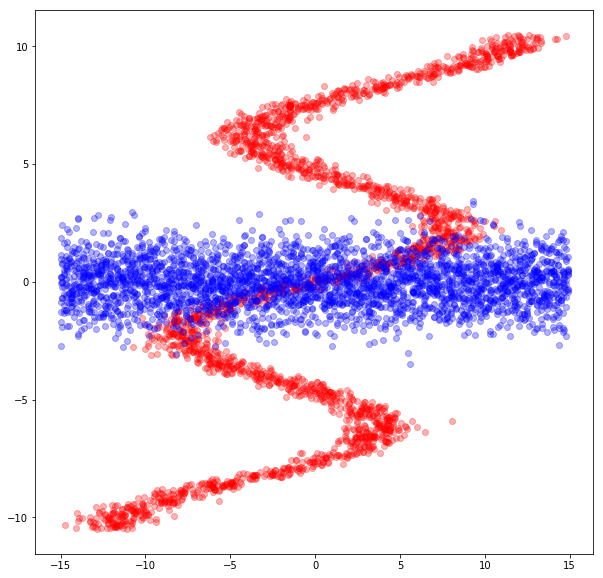

In [23]:
plt.figure(figsize=(10,10))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()